In [1]:
import os
import sys
import json

import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from model import BiLSTM

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), '..')))
from etl_data_preparing import DataPrepareETL

In [ ]:
model = BiLSTM()

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

In [16]:
train_loader, (X_valid, y_valid), (X_test, y_test) = DataPrepareETL(
    data="../preprocessing/data/BTCUSDT.csv",
    scaler="./static/BTCUSDT_MinMaxScaler.pkl"
).prepare_for_train(valid_size=.10, test_size=.10)

In [ ]:
static_dir = "static/"
best_model_filename = os.path.join(static_dir, "best_BiLSTM.pkl")
train(epochs=25, best_model_filename=best_model_filename, test_count=1000)

# Utils

In [17]:
def mae(x, y):
    with torch.no_grad():
        out = model(x)
        errors = abs(out - y)
    return errors

def train_one_epoch():
    train_losses = list()
    val_losses = list()
    model.train()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        model.zero_grad()
        out = model(X_batch)
        loss = loss_function(out, y_batch)
        loss.backward()
        optimizer.step()

        if (i+1) % 25 == 0:
            train_losses.append(loss.item())
            with torch.no_grad():
                val_out = model(X_valid)
                val_loss = loss_function(val_out, y_valid)
            val_losses.append(val_loss.item())

        if (i+1) % 100 == 0:
            print(f"Train Itteration: {i+1}, Train Loss: {loss.item()}, Valid Loss: {val_loss.item()}")

    return train_losses, val_losses


def train(epochs: int, best_model_filename: str, test_count: int = 1000):
    best_error = np.inf
    train_losses = list()
    val_losses = list()
    for epoch in range(epochs):
        tl, vl = train_one_epoch()
        train_losses.extend(tl)
        val_losses.extend(vl)
        epoch_errors = list()
        for i in range(0, test_count, 100):
            epoch_errors.append(mae(X_valid[i:i+100], y_valid[i:i+100]))
        epoch_errors = torch.cat(epoch_errors)
        if epoch_errors.mean().item() < best_error:
            torch.save(model, best_model_filename)
            best_error = epoch_errors.mean().item()
        print("Epoch:", epoch+1, "MAE:", epoch_errors.mean().item(), "STD:", epoch_errors.std().item())
    return train_losses, val_losses


In [2]:
history = json.load(open("./static/BiLSTM train history.json"))
history

{'train': [0.005177708342671394,
  0.00046148087130859494,
  7.478080806322396e-05,
  1.603160308150109e-05,
  1.5364994396804832e-05,
  1.1909249224117957e-05,
  1.1602583981584758e-05,
  8.14653503766749e-06,
  1.9835326384054497e-05,
  1.0124072105099913e-05,
  6.393282092176378e-06,
  6.546004442498088e-06,
  1.1973611435678322e-05,
  2.396679155935999e-05,
  9.216620128427166e-06,
  1.577120929141529e-05,
  5.4665524658048525e-06,
  1.5571098629152402e-05,
  6.174442205519881e-06,
  1.9016219084733166e-05,
  2.022306580329314e-05,
  3.5245975595898926e-05,
  2.962417420349084e-05,
  2.4519067665096372e-05,
  2.2556891053682193e-05,
  4.8298534238711e-05,
  2.926701563410461e-05,
  1.1452164471847937e-05,
  2.5470984837738797e-05,
  1.154497658717446e-05,
  0.0007442938513122499,
  2.478028545738198e-05,
  2.048030000878498e-05,
  1.0114243195857853e-05,
  5.625695393973729e-06,
  3.627761543611996e-06,
  7.712553269811906e-06,
  2.647750807227567e-05,
  1.0970687981171068e-05,
  1

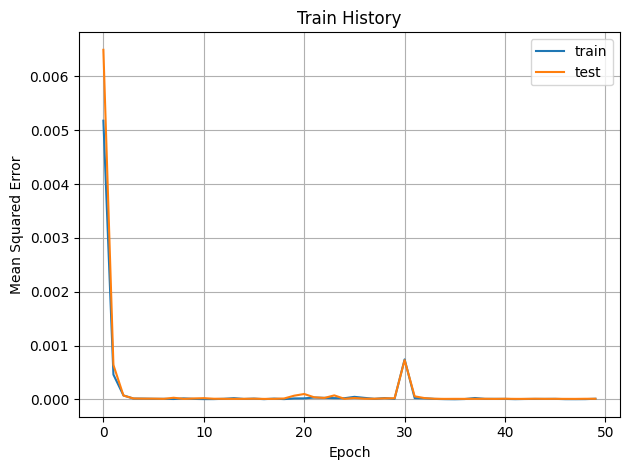

In [3]:
plt.plot(history["train"][:50], label="train")
plt.plot(history["valid"][:50], label="test")
plt.legend()
plt.title("Train History")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.tight_layout()
plt.savefig("./static/train history 50 epochs")